In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, BasicAer, execute
from qiskit.extensions.standard.rz import RZGate
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from tqdm import trange
# from SMPyBandits import *



For the state - determining circuit(where we mean state in the MDP and not quantum sense), we:
- prepare in X(+1) eigenstate
- rotate along Z axis by error theta
- measure in Y basis
Hence, p(+i) = cos ^ 2[(pi / 2 - theta) / 2] allowing us to distinguish between small positive and negative errors.
Note, we cannot distinguish between rotations by(pi / 2 + eps, pi / 2 - eps). Therefore, we assume errors lie within[-pi / 2, pi / 2].



In [27]:
def create_spectator_context_circuit(error_theta):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.h(qr)

    qc.rz(error_theta, qr)

    qc.sdg(qr)
    qc.h(qr)
    qc.measure(qr, cr)

    return qc


# explicit update function allows us to avoid creating a new ciruit object
# at every iteration
def update_spectator_circuit(qc, error_theta):
    inst, qarg, carg = qc.data[1]
    qc.data[1] = RZGate(error_theta), qarg, carg



For the reward - determining circuit, we:
- prepare in X(+1) eigenstate
- rotate along Z axis by error theta
- measure in X basis
Hence, p(+1) = cos ^ 2[theta / 2] allowing us to evaluation error correction reward.



In [28]:
def create_spectator_reward_circuit(error_theta):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.h(qr)

    qc.rz(error_theta, qr)

    qc.h(qr)
    qc.measure(qr, cr)

    return qc



In [29]:
qc = create_spectator_context_circuit(0.1 * np.pi)
qc.draw()


In [30]:
qc_small_pos = create_spectator_context_circuit(0.1 * np.pi)
qc_small_neg = create_spectator_context_circuit(-0.1 * np.pi)
sim_pos = execute(
    qc_small_pos, backend=BasicAer.get_backend('qasm_simulator'),
    shots=1000)
sim_neg = execute(
    qc_small_neg, backend=BasicAer.get_backend('qasm_simulator'),
    shots=1000)
print(sim_pos.result().get_counts())
print(sim_neg.result().get_counts())



{'0': 659, '1': 341}
{'0': 343, '1': 657}


In [34]:
# (action, reward) distribution for a given state
# in particular, we have two states: V0, V1
# @jitclass(spec)

class MDPNode:
    def __init__(self, num_arms, gamma=0.95):
        # action set
        self.thetas = np.pi * np.linspace(-1, 1, num_arms)
        # correspondingly indexed (reward | state, action) set
        # samples from beta(S, F) distribution
        self.estimated_rewards = np.ones(num_arms, dtype=np.float64)
        # (successes | arm)
        self.S = np.ones(num_arms, dtype=np.int)
        # (failures | arm)
        self.F = np.ones(num_arms, dtype=np.int)
        # discount factor
        self.gamma = gamma

    def resample_rewards(self):
        # estimated_rewards is drawn from beta(S, F) distribution for each arm
        # which enables exploration
        for i in range(len(self.estimated_rewards)):
            self.estimated_rewards[i] = np.random.beta(self.S[i], self.F[i])

    def optimal_theta(self):
        return self.thetas[np.argmax(self.estimated_rewards)]

    def discount(self):
        self.S = self.gamma * self.S
        self.F = self.gamma * self.F
        
    def success(self):
        self.discount()
        # update assuming success occurred when pulling currently optimal arm
        arm = np.argmax(self.estimated_rewards)
        self.S[arm] += 1

    def failure(self):
        self.discount()
        arm = np.argmax(self.estimated_rewards)
        self.F[arm] += 1



In [35]:
def mab(error_samples, num_arms=21):
    N = len(error_samples)
    outcomes = np.zeros(N)
    V0 = MDPNode(num_arms)
    V1 = MDPNode(num_arms)

    process_fidelity_corrected = np.zeros(N)
    process_fidelity_noop = np.zeros(N)

    spectator_context_qc = create_spectator_context_circuit(0)
    spectator_reward_qc = create_spectator_reward_circuit(0)
    for i in trange(N):
        update_spectator_circuit(spectator_context_qc, error_samples[i])

        # context measurement separates positive from negative rotations
        # if the rotation is +pi/4 we will draw 0 w.p. 1
        sim_1 = execute(
            spectator_context_qc, backend=BasicAer.get_backend(
                'qasm_simulator'),
            shots=1)
        outcome_1 = int(
            list(sim_1.result().get_counts().keys())[0]
        )
        outcomes[i] = outcome_1

        # contextual multi-arm bandit
        context = V0 if outcome_1 == 0 else V1
        # estimated rewards for arms are redrawn using Beta(#success, #failure)
        context.resample_rewards()
        correction_theta = context.optimal_theta()

        # rotations along the same axis commute
        update_spectator_circuit(spectator_reward_qc,
                                 error_samples[i] + correction_theta)
        sim_2 = execute(
            spectator_reward_qc,
            backend=BasicAer.get_backend('qasm_simulator'), shots=1)
        outcome_2 = int(
            list(sim_2.result().get_counts().keys())[0]
        )

        # if the correction is perfect then the reward measurement is 0 w.p. 1
        # the underlying distribution we are sampling is monotonic in fidelity
        if (outcome_2 == 0):
            context.success()
        else:
            context.failure()

        process_fidelity_corrected[i] = np.abs(rz(
            error_samples[i] + correction_theta).tr()) / 2
        process_fidelity_noop[i] = np.abs(rz(error_samples[i]).tr()) / 2

    return (V0, V1,
            process_fidelity_corrected, process_fidelity_noop, outcomes)



In [36]:
# unif [-alpha, alpha]

A = 0.01
mu_list = np.pi * np.array([A])
sigma_list = np.pi * np.array([A])

M = 10000
N = 5 * M

time_dependent_fn = np.vectorize(lambda x: np.pi * np.sin(2 * np.pi * x / M))

V0_sequence, V1_sequence = [], []
outcomes_sequence = []
fid_corrected_sequence, fid_noop_sequence = [], []


for mu, sigma in zip(mu_list, sigma_list):
    error_samples = np.random.normal(mu, sigma, N) + time_dependent_fn(np.arange(N))
    V0, V1, fid_corrected, fid_noop, outcomes = mab(error_samples)

    V0_sequence.append(V0)
    V1_sequence.append(V1)
    outcomes_sequence.append(outcomes)
    fid_corrected_sequence.append(fid_corrected)
    fid_noop_sequence.append(fid_noop)



100%|██████████| 50000/50000 [36:44<00:00, 22.68it/s] 


In [37]:
print("estimated arm reward given positive rotation context:")
print(V0_sequence[0].estimated_rewards)
print("given positive rotation context:")
print(V1_sequence[0].estimated_rewards)

print("\n")

print("average fidelity with correction: ", np.mean(fid_corrected_sequence[0]))
print("without correction: ", np.mean(fid_noop_sequence[0]))



estimated arm reward given positive rotation context:
[0.         0.         0.         0.         0.         0.44187279
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
given positive rotation context:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.41144796 0.16111364
 0.         0.         0.        ]


average fidelity with correction:  0.8582577083647907
without correction:  0.47336268444063434


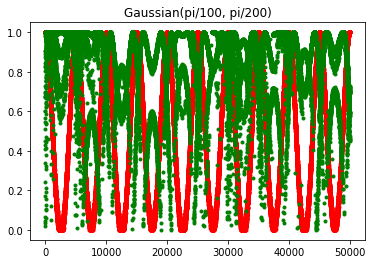

In [38]:
idx = np.linspace(1, N, N)
plt.figure()
plt.title("Gaussian(pi/100, pi/200)")
plt.plot(idx, fid_noop_sequence[0], 'r.', idx, fid_corrected_sequence[0], 'g.')
plt.show()

average fidelity with correction:  0.8371821283330927
without correction:  0.4733223348369069


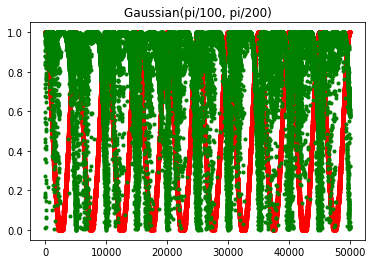

In [24]:
# ordinary TS
print("average fidelity with correction: ", np.mean(fid_corrected_sequence[0]))
print("without correction: ", np.mean(fid_noop_sequence[0]))


idx = np.linspace(1, N, N)
plt.figure()
plt.title("Gaussian(pi/100, pi/200)")
plt.plot(idx, fid_noop_sequence[0], 'r.', idx, fid_corrected_sequence[0], 'g.')
plt.show()

average fidelity with correction:  0.8582577083647907
without correction:  0.47336268444063434


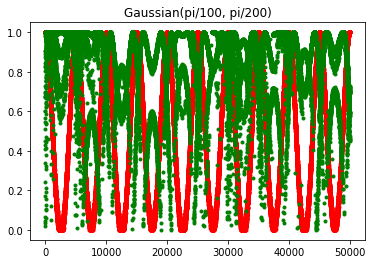

In [39]:
# TS with 0.99 discount
print("average fidelity with correction: ", np.mean(fid_corrected_sequence[0]))
print("without correction: ", np.mean(fid_noop_sequence[0]))


idx = np.linspace(1, N, N)
plt.figure()
plt.title("Gaussian(pi/100, pi/200)")
plt.plot(idx, fid_noop_sequence[0], 'r.', idx, fid_corrected_sequence[0], 'g.')
plt.show()